In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import itertools
from collections import defaultdict

In [2]:
#class Grid:
    #==================================#
    # Python Wrapper Class for 2D npArray
    # Stores values representing availibility
    # Expects tuple(x,y) format of values
    #==================================#
#    def __init__(self, size):
#        self.size = size
#        self.grid = np.empty((size, size), dtype= np.ulonglong)
    
#    def insert(self, Person_id, times):
#        self.grid[times] += 1*10**Person_id
#    def delete(self, Person_id, times):
#        self.grid[times] -= 1*10**Person_id
        
#    def insertMult(self, Person_id, times):
#        self.grid[tuple(zip(*times))] += 1*10**Person_id
        
#    def deleteMult(self, Person_id, times):
#        self.grid[tuple(zip(*times))] -= 1*10**Person_id
    
#    def isAvailable(self, Person_id, time):
#        if Person_id >= len(str(self.grid[time])):
#            return False
#        return str(self.grid[time])[::-1][Person_id] == '1'
    
#   def getTotal(self, time):
#       return sum(map(int, str(self.grid[time]) ))
    
#   def getNextAvailable(self, Person_id, time):
        
#       baseStr = str(self.grid[time])[::-1]
#       if Person_id >= len(baseStr):
#           return baseStr.rfind('1')
        
#       if baseStr[Person_id] == '1':
#           return Person_id
        
#       back = baseStr[Person_id:]
#       front = baseStr[:Person_id]
        #print(baseStr)
        #print("front: ", front, "distance: ", front[::-1].find("1"))
        #print("back: ", back, "distance: ", back.find("1"))
        
#       frontL = front[::-1].find("1")
#       backL = back.find("1")
        
#       if backL == -1 and frontL == -1:
#           return -1
#       elif backL < frontL or frontL == -1:
#           return Person_id+backL
#       elif frontL > backL or backL == -1:
#           return Person_id - frontL
        
#       return (Person_id-frontL, Person_id+backL)
    
#   def print(self):
#       print(self.grid)

In [3]:
class Grid:
    def __init__(self, size):
        self.size = size
        self.Grid = pd.DataFrame(None, columns= [(x//size, x%size) for x in range(size**2)], dtype = bool)
        
    def insert(self, idx, times: list):
            
        self.Grid.loc[idx] = [ x in set(times) for x in self.Grid.columns]
        
    def delete(self, idx):
        if idx in self.Grid.index:
            self.Grid.drop(index=idx, inplace= True)
        else:
            print("Not in index")
    
    def change(self, idx, times: list, value):
        self.Grid.loc[idx] = [ value if x in set(times) else y for x,y in zip(self.Grid.columns, self.Grid.loc[idx])]
    
    def isAvailable(self, idx, times: list):
        if idx not in self.Grid.index:
            print("Not an appropriate index")
            return False
        
        pos = self.Grid.index.get_loc(idx)
        return self.Grid.iloc[pos, times[0]*self.size + times[1]]
    
    def getTotal(self, times):
        return self.Grid[times].sum()
    def getTotalbyidx(self, idx):
        return self.Grid.loc[idx].sum()
    def getTotalSpots(self):
        return len(self.Grid.columns)
    def getAvailable(self, time):
        return self.Grid.loc[self.Grid[time] == True][time]
    
#    def getNextAvailable(self, time):
#        ser = self.getAvailable(time)
#        ser = ser.to_frame()
#        arr = []
#        for x in ser.index:
#            arr.append(self.getTotalbyidx(x))
            
#        ser["vals"] = arr
#        return ser.sort_values(by = "vals")

    def getNextAvailable(self, time):
        ser = self.getAvailable(time)
        return ser.sort_index(key = lambda x: [self.getTotalbyidx(y) for y in x])
    def print(self):
        print(self.Grid)
    
class Person:
    newid = itertools.count()
    def __init__(self, id = None, availability= set()):
        if id is None:
            self.id = next(Person.newid)
        else:
            self.id = id
            
        self.availability = set()
        
    def reset():
        Person.newid = itertools.count()
        
            

In [4]:
print (pd.options.display.max_columns)
print (pd.options.display.max_rows)

20
60


In [5]:
test = Grid(4)
#test.print()
test.insert(20, [(0,0),(0,3),(2,2)])

test.insert(0, [(0,3)])
test.insert(3, [(0,0)])
test.change(3, [(1,0)], True)

print("Test is Available: ", test.isAvailable(3, (1,1)), "\n" )
display(test.getAvailable((0,0)) )
print("\nTest Total by Row: ", test.getTotalbyidx(20))
print("Test Total by Column: ", test.getTotal((0,0)), "\n" )

display(test.getNextAvailable((0,0)) )
display(test.Grid)

Test is Available:  False 



20    True
3     True
Name: (0, 0), dtype: bool


Test Total by Row:  3
Test Total by Column:  2 



3     True
20    True
Name: (0, 0), dtype: bool

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
20,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [6]:
test.delete(4)
test.getTotal((2,2))

Not in index


1

In [7]:
test.print()

    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (1, 0)  (1, 1)  (1, 2)  (1, 3)  (2, 0)  \
20    True   False   False    True   False   False   False   False   False   
0    False   False   False    True   False   False   False   False   False   
3     True   False   False   False    True   False   False   False   False   

    (2, 1)  (2, 2)  (2, 3)  (3, 0)  (3, 1)  (3, 2)  (3, 3)  
20   False    True   False   False   False   False   False  
0    False   False   False   False   False   False   False  
3    False   False   False   False   False   False   False  


In [8]:
test.isAvailable(4, (2,2))

Not an appropriate index


False

In [9]:
test.isAvailable(3, (1,0))

True

# Things to try
min value of matrix

# Calculate the loss H(P(x)/m*n) + H(M(x)/X)
- Entropy of the person plus entropy of the space
    - minimize such that the total entropy of remaining spaces is the most possible
- where E(P(x)/m*n) is the entropy for person,P, and P(x) is total available
- where E(M(x)/X) is the entropy of available People, M(x), against total People, X
# Operations:
How to keep track of positions
How to deal with failure end state (is it reversible?)
How to represent success state (used dictionary)
Best way to find next position (sorted numpy array along index)

# Failure States:
When X > m*n
When dictionary reaches inf.
# Success state:
When all values in Dictonary are unique

In [10]:
GRID_SIZE = 48
Num_People = 26
def fillGrid(perc):
    return perc* (GRID_SIZE**2)
people = [Person() for x in range(Num_People)]

In [11]:
schedule = Grid(GRID_SIZE)

def createTupList(maxval, size):
    #s = set()
    #while len(s) != size:
    #    s.add(tuple(np.random.randint(maxval, size = 2, dtype = np.uint64)))
    #print("\n", list(s))
    #print("Length of list: ", len(s))
    #return list(s)
    return [tuple(np.random.randint(maxval, size=2, dtype=np.uint64)) for x in range(size)]

for person in people:
    r = np.random.randint(GRID_SIZE**2, dtype = np.uint64)
    #print(person.id)
    schedule.insert(person.id, createTupList(48, r))
    
#schedule.print()

In [12]:
for person in people:
    print(person.id, " Person available: ", schedule.getTotalbyidx(person.id))

0  Person available:  1029
1  Person available:  1260
2  Person available:  1152
3  Person available:  724
4  Person available:  1391
5  Person available:  556
6  Person available:  1300
7  Person available:  1199
8  Person available:  425
9  Person available:  289
10  Person available:  575
11  Person available:  452
12  Person available:  64
13  Person available:  1374
14  Person available:  1328
15  Person available:  692
16  Person available:  1243
17  Person available:  681
18  Person available:  793
19  Person available:  1355
20  Person available:  478
21  Person available:  1050
22  Person available:  196
23  Person available:  726
24  Person available:  1394
25  Person available:  342


In [13]:
for person in people:
    print(person.id, " Person available (by %): {:.4%}".format(schedule.getTotalbyidx(person.id)/schedule.getTotalSpots()))

0  Person available (by %): 44.6615%
1  Person available (by %): 54.6875%
2  Person available (by %): 50.0000%
3  Person available (by %): 31.4236%
4  Person available (by %): 60.3733%
5  Person available (by %): 24.1319%
6  Person available (by %): 56.4236%
7  Person available (by %): 52.0399%
8  Person available (by %): 18.4462%
9  Person available (by %): 12.5434%
10  Person available (by %): 24.9566%
11  Person available (by %): 19.6181%
12  Person available (by %): 2.7778%
13  Person available (by %): 59.6354%
14  Person available (by %): 57.6389%
15  Person available (by %): 30.0347%
16  Person available (by %): 53.9497%
17  Person available (by %): 29.5573%
18  Person available (by %): 34.4184%
19  Person available (by %): 58.8108%
20  Person available (by %): 20.7465%
21  Person available (by %): 45.5729%
22  Person available (by %): 8.5069%
23  Person available (by %): 31.5104%
24  Person available (by %): 60.5035%
25  Person available (by %): 14.8438%


In [14]:
EntropybyRow = np.zeros(shape=(Num_People,1))
EntropybyCol = np.zeros(shape=(1,GRID_SIZE**2))

for count, person in enumerate(people):
    prob = schedule.getTotalbyidx(person.id)/schedule.getTotalSpots()
    
    EntropybyRow[count] = entropy([prob, 1-prob])
    
for count, time in enumerate(schedule.Grid):
    prob = schedule.getTotal(time)/len(people)
        
    EntropybyCol[0,count] = entropy([prob, 1-prob])

disp = pd.DataFrame(EntropybyCol+EntropybyRow, columns= schedule.Grid.columns)

In [15]:
display(disp)

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(47, 38)","(47, 39)","(47, 40)","(47, 41)","(47, 42)","(47, 43)","(47, 44)","(47, 45)","(47, 46)","(47, 47)"
0,0.958626,1.304678,1.304678,1.353715,1.304678,1.269929,1.304678,1.368702,1.380583,1.227640,...,1.304678,1.304678,1.176988,1.176988,1.377622,1.269929,1.269929,1.353715,1.380583,1.332469
1,0.959936,1.305988,1.305988,1.355025,1.305988,1.271238,1.305988,1.370012,1.381893,1.228950,...,1.305988,1.305988,1.178298,1.178298,1.378932,1.271238,1.271238,1.355025,1.381893,1.333779
2,0.964337,1.310389,1.310389,1.359426,1.310389,1.275639,1.310389,1.374413,1.386294,1.233351,...,1.310389,1.310389,1.182699,1.182699,1.383333,1.275639,1.275639,1.359426,1.386294,1.338180
3,0.893638,1.239690,1.239690,1.288727,1.239690,1.204940,1.239690,1.303714,1.315595,1.162652,...,1.239690,1.239690,1.112000,1.112000,1.312634,1.204940,1.204940,1.288727,1.315595,1.267481
4,0.942659,1.288711,1.288711,1.337748,1.288711,1.253961,1.288711,1.352735,1.364616,1.211673,...,1.288711,1.288711,1.161021,1.161021,1.361655,1.253961,1.253961,1.337748,1.364616,1.316502
5,0.823785,1.169838,1.169838,1.218875,1.169838,1.135088,1.169838,1.233862,1.245743,1.092800,...,1.169838,1.169838,1.042148,1.042148,1.242782,1.135088,1.135088,1.218875,1.245743,1.197629
6,0.956061,1.302114,1.302114,1.351150,1.302114,1.267364,1.302114,1.366138,1.378019,1.225076,...,1.302114,1.302114,1.174424,1.174424,1.375057,1.267364,1.267364,1.351150,1.378019,1.329905
7,0.963504,1.309556,1.309556,1.358593,1.309556,1.274807,1.309556,1.373580,1.385462,1.232519,...,1.309556,1.309556,1.181867,1.181867,1.382500,1.274807,1.274807,1.358593,1.385462,1.337348
8,0.749281,1.095334,1.095334,1.144371,1.095334,1.060584,1.095334,1.159358,1.171239,1.018296,...,1.095334,1.095334,0.967644,0.967644,1.168278,1.060584,1.060584,1.144371,1.171239,1.123125
9,0.648803,0.994856,0.994856,1.043892,0.994856,0.960106,0.994856,1.058880,1.070761,0.917818,...,0.994856,0.994856,0.867166,0.867166,1.067800,0.960106,0.960106,1.043892,1.070761,1.022647


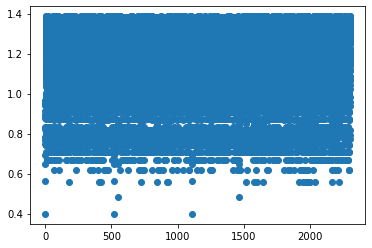

In [16]:
plot = plt.scatter(np.arange(len(disp.columns))+ np.zeros(shape=(len(disp.index), 1), dtype = int), disp.to_numpy())
plt.show()

In [17]:
def getBestSpot(people, grid):
    EntropybyRow = np.zeros(shape=(Num_People,1))
    EntropybyCol = np.zeros(shape=(1,GRID_SIZE**2))

    for count, person in enumerate(people):
        prob = schedule.getTotalbyidx(person.id)/schedule.getTotalSpots()

        EntropybyRow[count] = entropy([prob, 1-prob])

    for count, time in enumerate(schedule.Grid):
        prob = schedule.getTotal(time)/len(people)
        
        EntropybyCol[0,count] = entropy([prob, 1-prob])
    
    EntTable = EntropybyCol+EntropybyRow
    EntTable[~schedule.Grid.to_numpy()] = np.inf
            
    tableInd = EntTable.argsort(axis=1)
 
    best = {person.id: table[0] for person, table in zip(people ,tableInd)}
    idxCt = {}
    for k in best:
        idxCt[k] = 0
        
    #print(best)
    while len(set(best.values())) != len(best):
        last = {}
        for count, k in enumerate(best):
            best[k] = tableInd[count, idxCt[k]]
            
            if best[k] not in last:
                last[best[k]] = k
                #print(last)
            else:
                #compare with last instance
                #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                test_last = tableInd[last[best[k]], idxCt[last[best[k]]]+1 ]
                test_new = tableInd[count, idxCt[k]+1]
                if EntTable[ last[best[k]] , best[ last[best[k]] ] ] > EntTable[count, best[k]]:
                    #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                    #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                    
                    
                    if not np.isinf(EntTable[ last[best[k]], test_last]):
                        idxCt[ last[best[k]] ] += 1
                    else:
                        print("Testing Other... ")
                        if not np.isinf(EntTable[count, test_new]):
                            idxCt[k] += 1
                        else:
                            print("Unresolvable")
                            return None
                else:
                    if not np.isinf(EntTable[count, test_new]):
                        idxCt[k] += 1
                    else:
                        print("Testing Other... ")
                        if not np.isinf(EntTable[ last[best[k]], test_last]):
                            idxCt[ last[best[k]] ] += 1
                        else:
                            print("Unresolvable")
                            return None
                    
                #update to current instance
                last[best[k]] = k
        
    return best
getBestSpot(people, schedule)


{0: 1515,
 1: 1462,
 2: 1044,
 3: 1581,
 4: 551,
 5: 181,
 6: 1112,
 7: 2002,
 8: 2168,
 9: 1951,
 10: 917,
 11: 1851,
 12: 726,
 13: 0,
 14: 2038,
 15: 228,
 16: 924,
 17: 517,
 18: 2225,
 19: 847,
 20: 715,
 21: 1975,
 22: 408,
 23: 1599,
 24: 1990,
 25: 1948}